In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/metadata.zip ./

In [ ]:
!unzip metadata.zip

Archive:  metadata.zip
  inflating: class_dict.csv          
  inflating: metadata.csv            
  inflating: train/100694_mask.png   
  inflating: train/100694_sat.jpg    
  inflating: train/102122_mask.png   
  inflating: train/102122_sat.jpg    
  inflating: train/10233_mask.png    
  inflating: train/10233_sat.jpg     
  inflating: train/103665_mask.png   
  inflating: train/103665_sat.jpg    
  inflating: train/103730_mask.png   
  inflating: train/103730_sat.jpg    
  inflating: train/104113_mask.png   
  inflating: train/104113_sat.jpg    
  inflating: train/10452_mask.png    
  inflating: train/10452_sat.jpg     
  inflating: train/10901_mask.png    
  inflating: train/10901_sat.jpg     
  inflating: train/111335_mask.png   
  inflating: train/111335_sat.jpg    
  inflating: train/114433_mask.png   
  inflating: train/114433_sat.jpg    
  inflating: train/114473_mask.png   
  inflating: train/114473_sat.jpg    
  inflating: train/114577_mask.png   
  inflating: train/114577_s

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Load the metadata
metadata_path = "metadata.csv"

metadata = pd.read_csv(metadata_path)
metadata.isna().sum()

,0
image_id,0
split,0
sat_image_path,0
mask_path,343


In [ ]:
metadata.shape

(1146, 4)

In [ ]:
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png


In [ ]:
metadata.split.unique()

array(['train', 'valid', 'test'], dtype=object)

In [ ]:
class_dict_path = "class_dict.csv"
class_dict = pd.read_csv(class_dict_path)
class_dict

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [ ]:
class_dict.dtypes

,0
name,object
r,int64
g,int64
b,int64


In [ ]:
# Create a mapping from (r, g, b) to class index
class_map = {(row["r"], row["g"], row["b"]): idx for idx, row in class_dict.iterrows()}
class_map

{(0, 255, 255): 0,
 (255, 255, 0): 1,
 (255, 0, 255): 2,
 (0, 255, 0): 3,
 (0, 0, 255): 4,
 (255, 255, 255): 5,
 (0, 0, 0): 6}

In [ ]:
metadata_train = metadata[metadata["split"] == "train"]
metadata_train

,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png
...,...,...,...,...
798,992507,train,train/992507_sat.jpg,train/992507_mask.png
799,994520,train,train/994520_sat.jpg,train/994520_mask.png
800,995492,train,train/995492_sat.jpg,train/995492_mask.png
801,997521,train,train/997521_sat.jpg,train/997521_mask.png


In [ ]:
metadata_train.shape

(803, 4)

In [ ]:
# Initialize lists to hold images and masks
images = []
masks = []

# Set image size
img_size = (128, 128)


for idx, row in metadata_train.iterrows():
    img_path = row["sat_image_path"]
    mask_path = row["mask_path"]

    img = Image.open(img_path).resize(img_size)
    images.append(np.array(img))

    mask = Image.open(mask_path).resize(img_size, Image.NEAREST)
    mask_array = np.array(mask)

    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)
    for color, idx in class_map.items():
        color = np.array(color)  # Convert to numpy array
        match = np.all(mask_array == color, axis=-1)
        class_indices[match] = idx

    masks.append(class_indices)

In [ ]:
# Normalize pixels to 0 to 1 range and convert to array
images = np.array(images) / 255.0
masks = np.array(masks)

In [ ]:
print(f"Image dimensions: {images.shape}\nMask dimensions: {masks.shape}")

Image dimensions: (803, 128, 128, 3)
Mask dimensions: (803, 128, 128)


In [ ]:
# Add channel dimension to make it equal to image dimensions or it won't work for combined processing inside model.
masks = np.expand_dims(masks, axis=-1)  # -1 => as last dimension
print(f"Mask dimensions: {masks.shape}")

Mask dimensions: (803, 128, 128, 1)


In [ ]:
# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=42)

In [ ]:
X_val.shape

(81, 128, 128, 3)

In [ ]:
X_train.shape

(722, 128, 128, 3)

In [ ]:
num_classes = 7

In [ ]:
# U-Net Model with VGG16 Encoder
base_model = VGG16(include_top=False, weights="imagenet", input_shape=(128, 128, 3))

# Encoder
x1 = base_model.get_layer("block1_conv2").output
x2 = base_model.get_layer("block2_conv2").output
x3 = base_model.get_layer("block3_conv3").output
x4 = base_model.get_layer("block4_conv3").output

# Bottleneck
b = Conv2D(512, (3, 3), activation="relu", padding="same")(x4)
b = Conv2D(512, (3, 3), activation="relu", padding="same")(b)

# Decoder
u1 = UpSampling2D((2, 2))(b)
u1 = concatenate([u1, x3])
u1 = Conv2D(256, (3, 3), activation="relu", padding="same")(u1)
u1 = Conv2D(256, (3, 3), activation="relu", padding="same")(u1)

u2 = UpSampling2D((2, 2))(u1)
u2 = concatenate([u2, x2])
u2 = Conv2D(128, (3, 3), activation="relu", padding="same")(u2)
u2 = Conv2D(128, (3, 3), activation="relu", padding="same")(u2)

u3 = UpSampling2D((2, 2))(u2)
u3 = concatenate([u3, x1])
u3 = Conv2D(64, (3, 3), activation="relu", padding="same")(u3)
u3 = Conv2D(64, (3, 3), activation="relu", padding="same")(u3)

outputs = Conv2D(num_classes, (1, 1), activation="softmax")(u3)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

# Define callbacks
callbacks = [
    ModelCheckpoint("unet_model1.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=8,
    validation_split=0.1,
    callbacks=callbacks,
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 370ms/step - accuracy: 0.5079 - loss: 4.1146 - val_accuracy: 0.6068 - val_loss: 1.3018
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 138ms/step - accuracy: 0.5369 - loss: 1.3107 - val_accuracy: 0.5530 - val_loss: 1.2700
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.5714 - loss: 1.2244 - val_accuracy: 0.6193 - val_loss: 1.1177
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.6064 - loss: 1.1304 - val_accuracy: 0.5906 - val_loss: 1.1539
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6121 - loss: 1.1291 - val_accuracy: 0.6035 - val_loss: 1.1193
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.6456 - loss: 1.0718 - val_accuracy: 0.6440 - val_loss: 1.0280
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.6362 - loss: 1.0332 - val_accuracy: 0.6520 - val_loss: 1.0532
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.6398 - loss: 1.0540 - val_accu

In [ ]:
!cp /content/unet_model1.keras /content/drive/MyDrive/Models_1/

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Models_1/unet_model1.keras")

In [ ]:
# Predict on validation set
predictions = model.predict(X_val)

3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step


In [ ]:
# for prediction in predictions:
#     print(prediction)
#     break
# # [8.06242526e-02 5.12124598e-01 1.50406763e-01 ... 2.82596368e-02 1.70164704e-01 1.55683961e-02]

[[[3.95102389e-02 7.30799973e-01 6.86219633e-02 ... 1.46425907e-02
   1.12851530e-01 1.12744165e-03]
  [2.85622291e-02 7.76600897e-01 7.04617649e-02 ... 3.69660999e-03
   1.08062632e-01 3.33185599e-04]
  [2.55714580e-02 8.33464205e-01 5.70796914e-02 ... 1.93142483e-03
   7.36733750e-02 2.50557583e-04]
  ...
  [4.43218909e-02 7.44918764e-01 6.95048496e-02 ... 6.09763805e-03
   2.97696814e-02 2.75979080e-04]
  [8.36364105e-02 5.91731608e-01 8.14526901e-02 ... 1.22559946e-02
   4.66749109e-02 6.89436507e-04]
  [1.15607359e-01 5.39691865e-01 8.00342932e-02 ... 2.86478158e-02
   5.50074205e-02 4.15504165e-03]]

 [[2.43729651e-02 7.46780455e-01 9.10773054e-02 ... 7.33488658e-03
   1.17459469e-01 4.77170659e-04]
  [1.75089445e-02 7.72976577e-01 6.82953969e-02 ... 2.08643265e-03
   1.33309811e-01 7.33404522e-05]
  [1.53633859e-02 8.16121936e-01 5.23296744e-02 ... 1.61514559e-03
   1.09584458e-01 7.06118808e-05]
  ...
  [1.54733639e-02 7.40321398e-01 7.85164982e-02 ... 5.05492184e-03
   1.22054

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


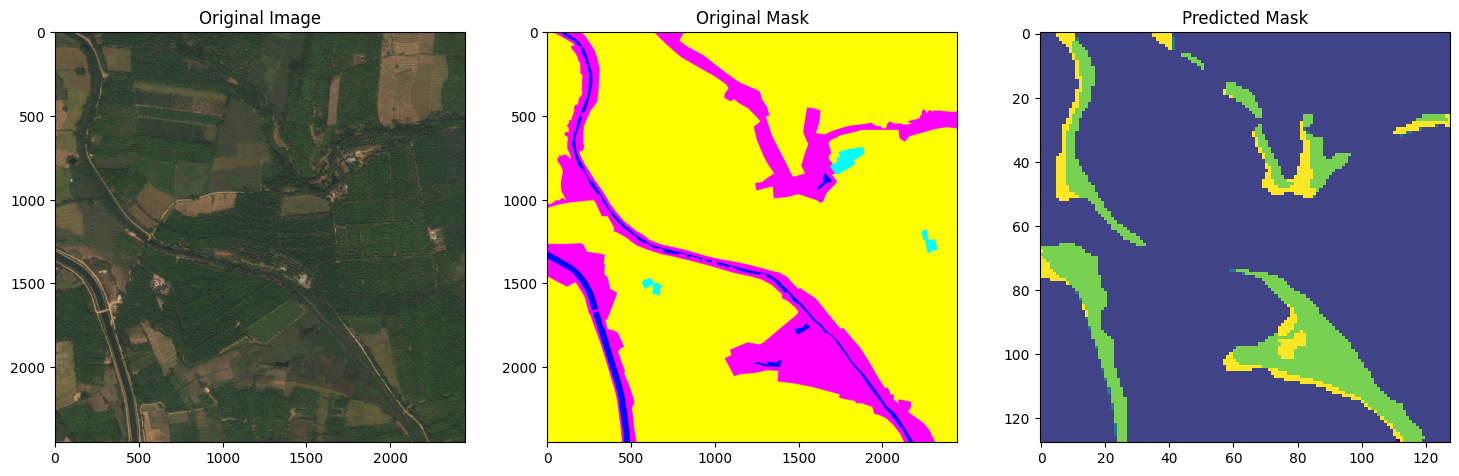

In [ ]:
# Path to your original mask image
original_mask_path = '/content/train/119_mask.png'
original_image_path = '/content/train/119_sat.jpg'

# Load the original mask image
original_mask = Image.open(original_mask_path)
original_image = Image.open(original_image_path)


image = Image.open(original_mask_path).resize((128, 128))
image_array = np.array(image) / 255.0  # Normalize
image_array = np.expand_dims(image_array, axis=0)

# Make prediction
prediction = model.predict(image_array)

original_mask_array = np.array(original_mask)
original_image_array = np.array(original_image)

plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_array, cmap="tab20b")

# Original Mask
plt.subplot(1, 3, 2)
plt.title("Original Mask")
plt.imshow(original_mask_array, cmap="gray")

# Predicted Mask
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(np.argmax(prediction[0], axis=-1))

plt.show()

Converted 1535 barren pixels to green in circular patterns.


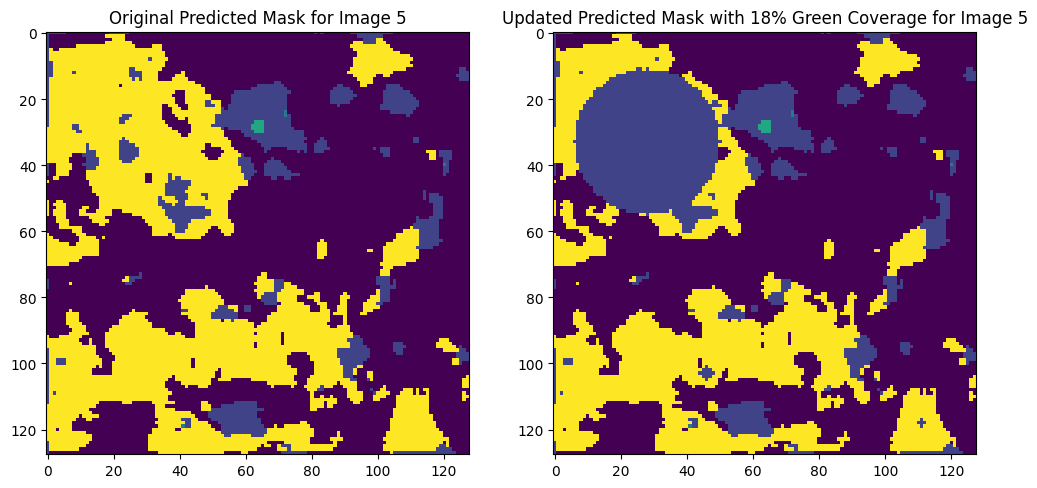

Converted 431 barren pixels to green in circular patterns.


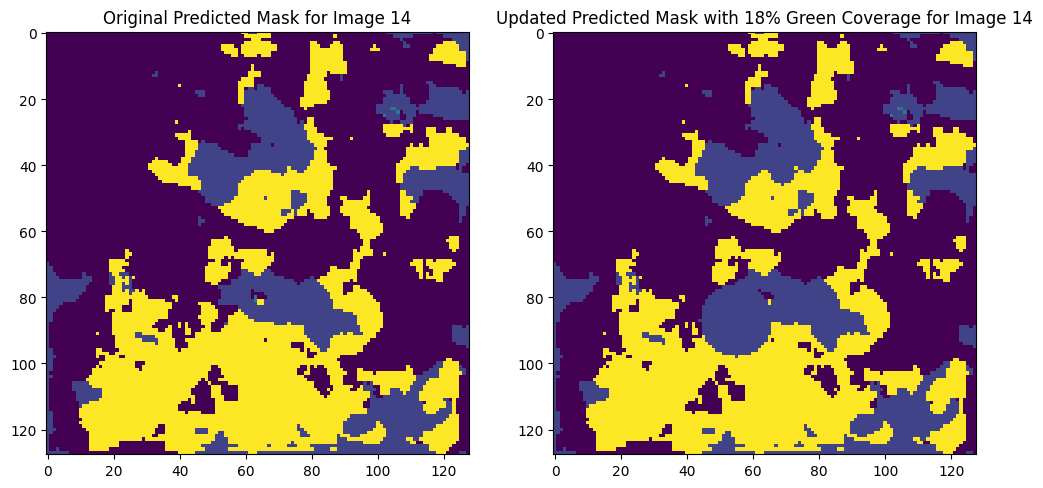

Converted 1192 barren pixels to green in circular patterns.


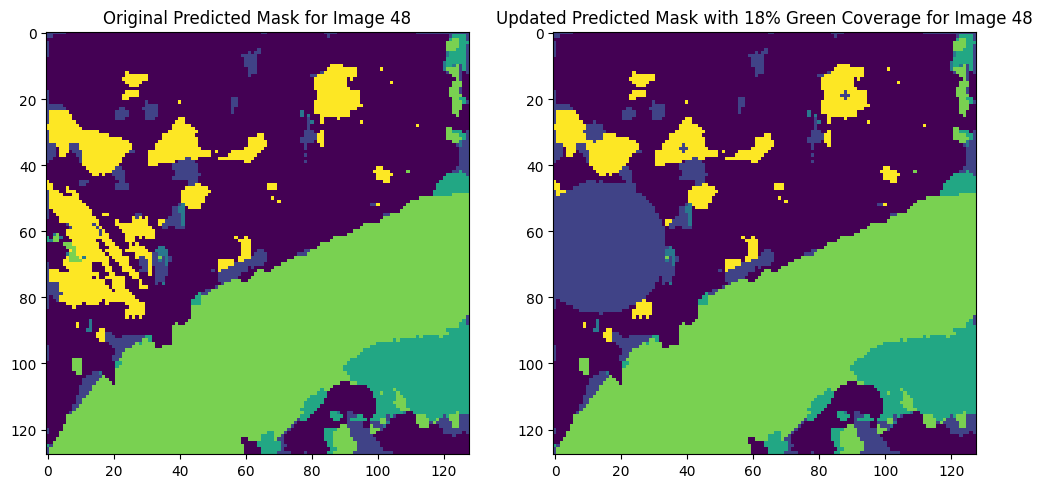

Converted 895 barren pixels to green in circular patterns.


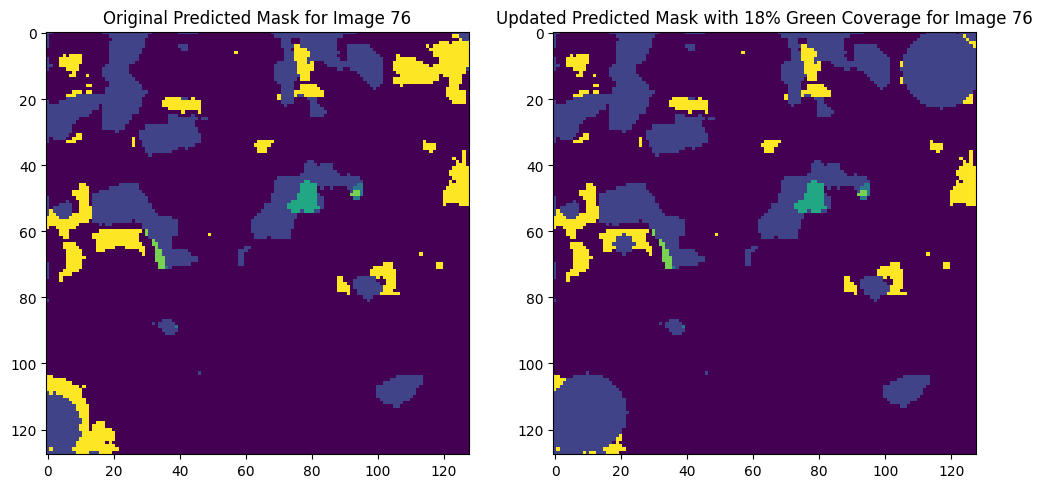

In [ ]:
# target_green_coverage = 18.0
# forest_class_index = 3
# agriculture_class_index = 1
# barren_land_class_index = 5

# for i, prediction in enumerate(predictions):
#     # Convert your prediction to an image format
#     predicted_mask = np.argmax(prediction, axis=-1)

#     # Calculate the total number of pixels
#     total_pixels = predicted_mask.shape[0] * predicted_mask.shape[1]

#     # Calculate current green coverage
#     green_pixels = np.sum(
#         (predicted_mask == forest_class_index)
#         | (predicted_mask == agriculture_class_index)
#     )
#     current_green_coverage = (green_pixels / total_pixels) * 100

#     # If green coverage is already 18% or more, skip this image
#     if current_green_coverage >= target_green_coverage:
#         continue

#     # Make a copy of the predicted mask before modification
#     original_predicted_mask = predicted_mask.copy()

#     # Calculate the required additional green pixels
#     target_green_pixels = int((target_green_coverage / 100) * total_pixels)
#     additional_green_pixels_needed = target_green_pixels - green_pixels

#     if additional_green_pixels_needed > 0:
#         # Identify barren land pixels
#         barren_pixels = np.where(predicted_mask == barren_land_class_index)

#         # Create a mask with barren pixels set to 1 and others set to 0
#         barren_mask = np.zeros_like(predicted_mask, dtype=np.uint8)
#         barren_mask[barren_pixels] = 1

#         # Find contours of barren land areas
#         contours, _ = cv2.findContours(
#             barren_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#         )

#         # Sort contours by area in descending order
#         contours = sorted(contours, key=cv2.contourArea, reverse=True)

#         converted_pixels = 0
#         for contour in contours:
#             if converted_pixels >= additional_green_pixels_needed:
#                 break

#             # Find the minimum enclosing circle for the contour
#             (x, y), radius = cv2.minEnclosingCircle(contour)
#             center = (int(x), int(y))
#             radius = int(radius)

#             # Determine the maximum circle size to fit the required number of pixels
#             while radius > 0 and converted_pixels < additional_green_pixels_needed:
#                 # Draw a circle with green color (agriculture)
#                 mask_with_circle = np.zeros_like(predicted_mask, dtype=np.uint8)
#                 cv2.circle(
#                     mask_with_circle, center, radius, agriculture_class_index, -1
#                 )

#                 # Calculate the number of new green pixels that would be added
#                 new_green_pixels = np.sum(mask_with_circle == agriculture_class_index)

#                 if converted_pixels + new_green_pixels > additional_green_pixels_needed:
#                     # Reduce radius to fit the exact number of required pixels
#                     radius -= 1
#                 else:
#                     # Update the predicted mask
#                     predicted_mask[mask_with_circle == agriculture_class_index] = (agriculture_class_index)
#                     converted_pixels += new_green_pixels
#                     break

#         print(f"Converted {converted_pixels} barren pixels to green in circular patterns.")

#         # Display the original and updated masks side by side for each image
#         plt.figure(figsize=(12, 6))

#         # Original predicted mask
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_predicted_mask)
#         plt.title(f"Original Predicted Mask for Image {i}")

#         # Updated predicted mask with green space allocation
#         plt.subplot(1, 2, 2)
#         plt.imshow(predicted_mask)
#         plt.title(f"Updated Predicted Mask with 18% Green Coverage for Image {i}")

#         plt.show()

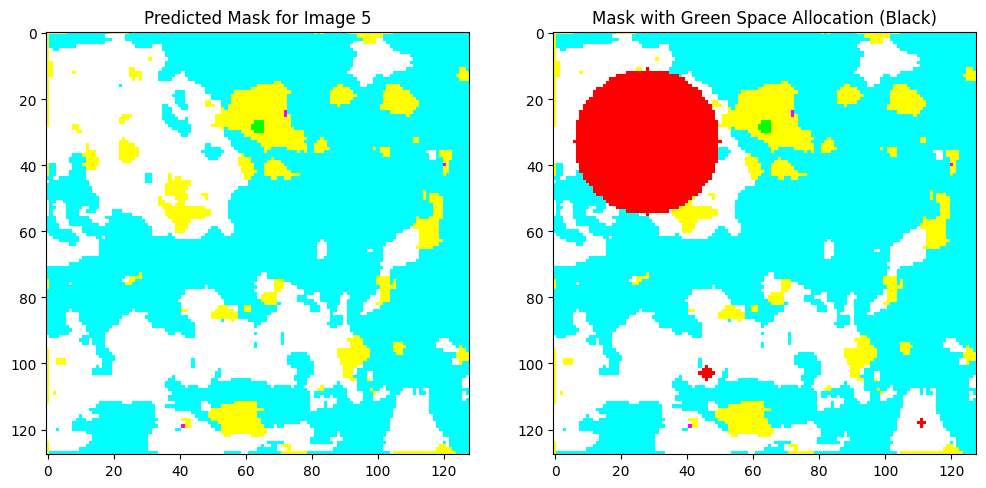

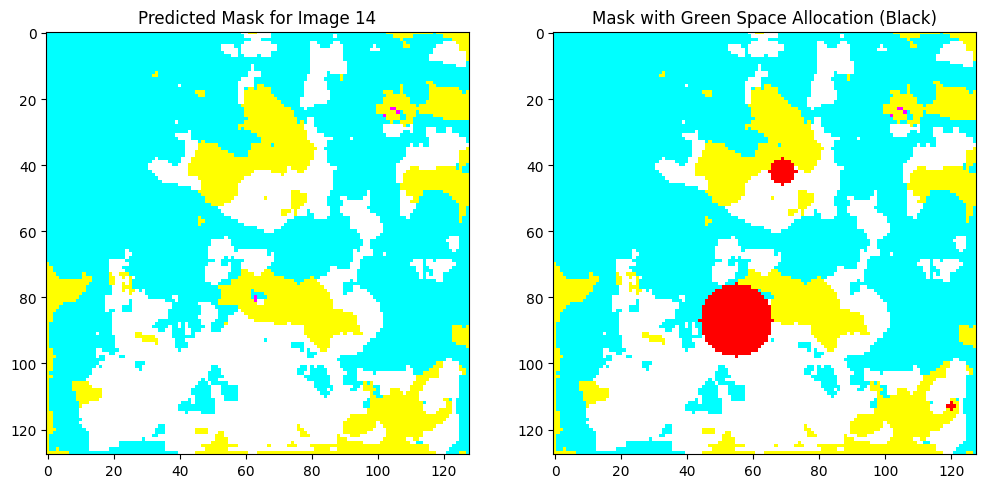

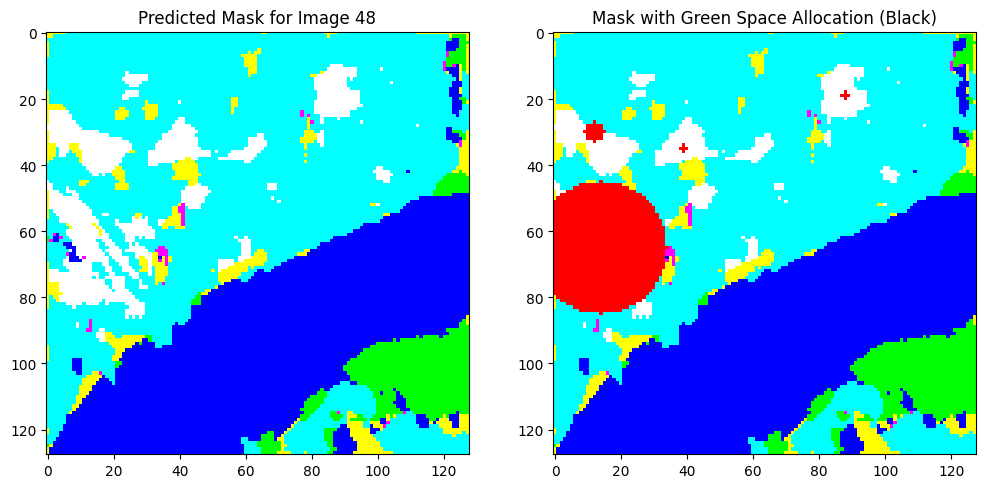

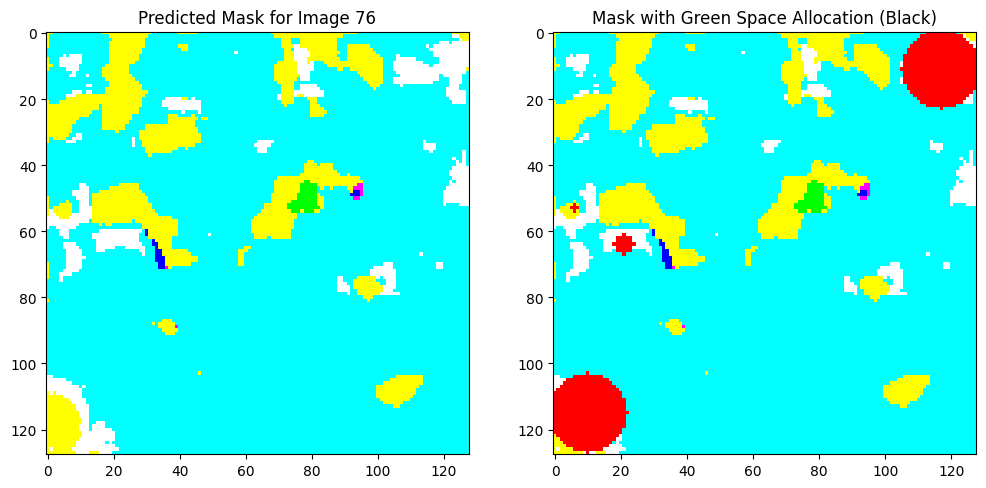

In [ ]:
# Define the original colors for each class
class_colors = {
    0: (0, 255, 255),  # Urban - Cyan
    1: (255, 255, 0),  # Agriculture - Yellow
    2: (255, 0, 255),  # Rangeland - Magenta
    3: (0, 255, 0),  # Forest - Green
    4: (0, 0, 255),  # Water - Blue
    5: (255, 255, 255),  # Barren - White
    6: (0, 0, 0),  # Unknown - Black
    255:(255,0,0), # allocated -red
}


# Function to convert predicted mask to original colored mask
def convert_to_color_mask(prediction, class_colors):
    color_mask = np.zeros((*prediction.shape, 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[prediction == class_idx] = color
    return color_mask

target_green_coverage = 18.0  # Target green coverage in percent
forest_class_index = 3  # Index for 'forest-land'
agriculture_class_index = 1  # Index for 'agriculture-land'
barren_land_class_index = 5  # Index for 'barren-land'

# Loop through each predicted mask
for i, prediction in enumerate(predictions):
    # Convert the predicted mask to class indices
    predicted_class_mask = np.argmax(prediction, axis=-1)

    # Calculate the total number of pixels
    total_pixels = predicted_class_mask.shape[0] * predicted_class_mask.shape[1]

    # Calculate current green coverage
    green_pixels = np.sum(
        (predicted_class_mask == forest_class_index)
        | (predicted_class_mask == agriculture_class_index)
    )
    current_green_coverage = (green_pixels / total_pixels) * 100

    # For green coverage less than the target
    if current_green_coverage < target_green_coverage:
        # Make a copy of the predicted mask before modification
        original_predicted_class_mask = predicted_class_mask.copy()

        # Calculate the required additional green pixels
        target_green_pixels = int((target_green_coverage / 100) * total_pixels)
        additional_green_pixels_needed = target_green_pixels - green_pixels

        if additional_green_pixels_needed > 0:
            # Identify barren land pixels
            barren_pixels = np.where(predicted_class_mask == barren_land_class_index)

            # Create a mask with barren pixels set to 1 and others set to 0
            barren_mask = np.zeros_like(predicted_class_mask, dtype=np.uint8)
            barren_mask[barren_pixels] = 1

            # Find contours of barren land areas
            contours, _ = cv2.findContours(
                barren_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            # Sort contours by area in descending order
            contours = sorted(contours, key=cv2.contourArea, reverse=True)

            converted_pixels = 0
            for contour in contours:
                if converted_pixels >= additional_green_pixels_needed:
                    break

                # Find the minimum enclosing circle for the contour
                (x, y), radius = cv2.minEnclosingCircle(contour)
                center = (int(x), int(y))
                radius = int(radius)

                # Determine the maximum circle size to fit the required number of pixels
                while radius > 0 and converted_pixels < additional_green_pixels_needed:
                    # Draw a circle for visualization
                    mask_with_circle = np.zeros_like(
                        predicted_class_mask, dtype=np.uint8
                    )
                    cv2.circle(mask_with_circle, center, radius, 255, -1)

                    # Calculate the number of new green pixels that would be added
                    new_green_pixels = np.sum(mask_with_circle == 255)

                    if (
                        converted_pixels + new_green_pixels
                        > additional_green_pixels_needed
                    ):
                        # Reduce radius to fit the exact number of required pixels
                        radius -= 1
                    else:
                        # Update the predicted mask with the visualization circle
                        original_predicted_class_mask[mask_with_circle == 255] = 255
                        converted_pixels += new_green_pixels
                        break

        # Convert the original and updated predicted masks to color images
        original_color_mask = convert_to_color_mask(predicted_class_mask, class_colors)
        updated_color_mask = convert_to_color_mask(
            original_predicted_class_mask, class_colors
        )

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(original_color_mask)
        plt.title(f"Predicted Mask for Image {i}")

        plt.subplot(1, 2, 2)
        plt.imshow(updated_color_mask)
        plt.title(f"Mask with Green Space Allocation (Black)")

        plt.show()